In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

--- Image Information ---
Dimensions (Height, Width, Channels): (1207, 1207, 3)
Pixel Value Range: (np.uint8(0), np.uint8(253))
Mean Pixel Value: 67.91
Standard Deviation of Pixel Values: 56.75
Number of Unique Colors: 256


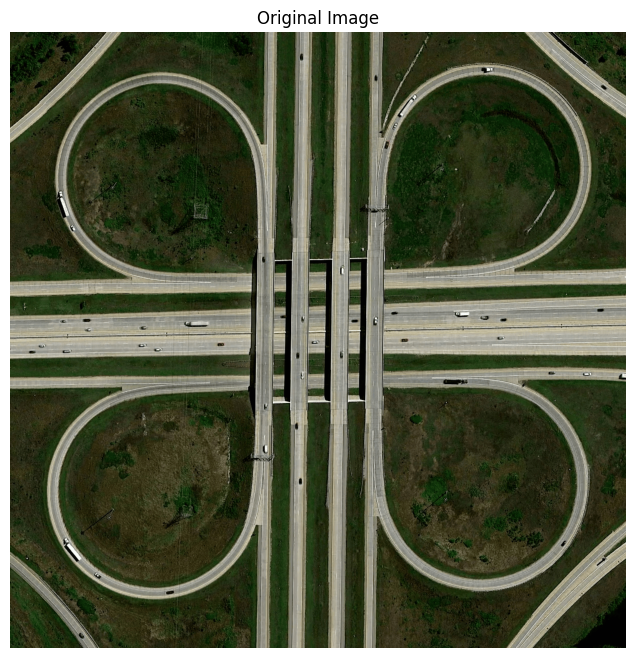

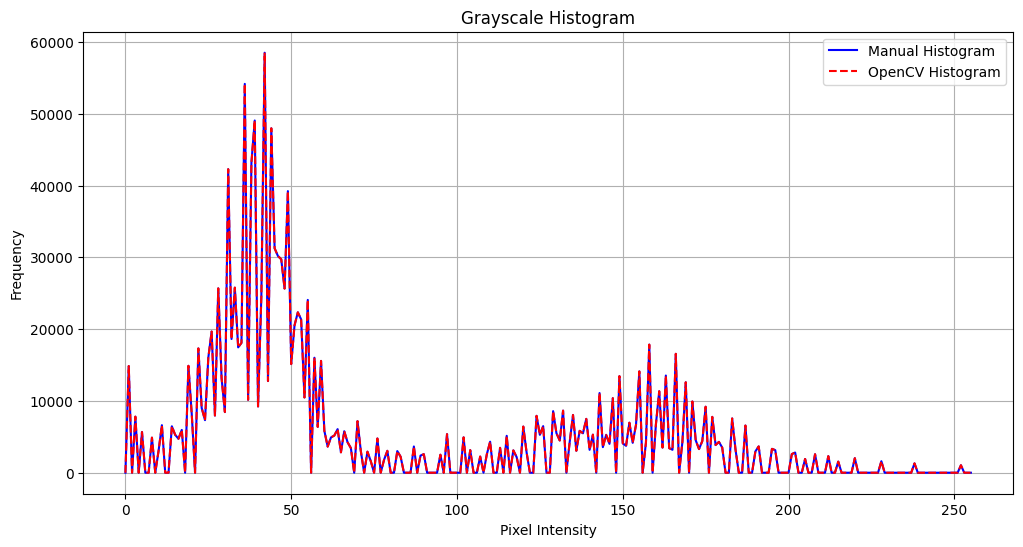

In [4]:
def load_cloverleaf_image(filepath):
    image = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    dimensions = image.shape
    pixel_range = (image.min(), image.max())
    mean_pixel_value = image.mean()
    std_pixel_value = image.std()
    unique_colors = len(np.unique(image.reshape(-1, image.shape[2]), axis=0))
    print("--- Image Information ---")
    print(f"Dimensions (Height, Width, Channels): {dimensions}")
    print(f"Pixel Value Range: {pixel_range}")
    print(f"Mean Pixel Value: {mean_pixel_value:.2f}")
    print(f"Standard Deviation of Pixel Values: {std_pixel_value:.2f}")
    print(f"Number of Unique Colors: {unique_colors}")
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
    return image

def calculate_histogram(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    histogram = np.zeros(256)
    for pixel in grayscale.ravel():
        histogram[pixel] += 1
    plt.figure(figsize=(12, 6))
    plt.plot(histogram, label="Manual Histogram", color='blue')
    opencv_hist = cv2.calcHist([grayscale], [0], None, [256], [0, 256]).ravel()
    plt.plot(opencv_hist, label="OpenCV Histogram", linestyle='dashed', color='red')
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

filepath = "../archive/cloverleaf_interchange.png"
cloverleaf_image = load_cloverleaf_image(filepath)
calculate_histogram(cloverleaf_image)

--- Preprocessing Steps ---
Step 1: Converted to grayscale for easier processing of intensity values.
Step 2: Applied Gaussian Blur with a kernel size of (5, 5) to reduce noise.
Step 3: Enhanced contrast using CLAHE to emphasize cloverleaf structures.
CLAHE improves local contrast, making features like edges and boundaries more distinguishable. Clip limit (2.0) avoids over-enhancement, and tile grid size (8, 8) ensures local contrast adjustment in small regions.
Step 4: Closed gaps in edges using morphological operations with a 5x5 kernel.
Step 5: Detected edges using Canny with thresholds 50 and 150.


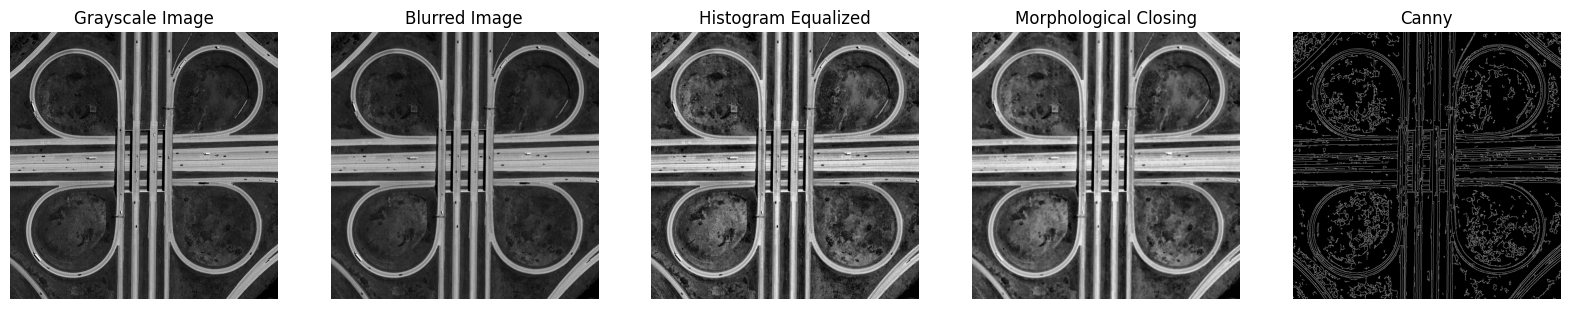

In [5]:
def preprocess_image(image):
    print("--- Preprocessing Steps ---")

    # Convert to grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print("Step 1: Converted to grayscale for easier processing of intensity values.")

    # Apply Gaussian Blur for noise reduction
    blurred = cv2.GaussianBlur(grayscale, (5, 5), 0)
    print("Step 2: Applied Gaussian Blur with a kernel size of (5, 5) to reduce noise.")

    # Apply adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(blurred)
    print("Step 3: Enhanced contrast using CLAHE to emphasize cloverleaf structures.")
    print("CLAHE improves local contrast, making features like edges and boundaries more distinguishable. Clip limit (2.0) avoids over-enhancement, and tile grid size (8, 8) ensures local contrast adjustment in small regions.")

    # Apply morphological operations to close gaps in edges
    kernel = np.ones((5, 5), np.uint8)
    closed_edges = cv2.morphologyEx(equalized, cv2.MORPH_CLOSE, kernel)
    print("Step 4: Closed gaps in edges using morphological operations with a 5x5 kernel.")

    # Edge detection using Canny
    edges = cv2.Canny(closed_edges, 50, 150)
    print("Step 5: Detected edges using Canny with thresholds 50 and 150.")

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 5, 1)
    plt.imshow(grayscale, cmap="gray")
    plt.title("Grayscale Image")
    plt.axis("off")
    plt.subplot(1, 5, 2)
    plt.imshow(blurred, cmap="gray")
    plt.title("Blurred Image")
    plt.axis("off")
    plt.subplot(1, 5, 3)
    plt.imshow(equalized, cmap="gray")
    plt.title("Histogram Equalized")
    plt.axis("off")
    plt.subplot(1, 5, 4)
    plt.imshow(closed_edges, cmap="gray")
    plt.title("Morphological Closing")
    plt.axis("off")
    plt.subplot(1, 5, 5)
    plt.imshow(edges, cmap="gray")
    plt.title("Canny")
    plt.axis("off")
    plt.show()
    return blurred

proecessed_image = preprocess_image(cloverleaf_image)

The Blurred Image is likely the best for detecting the cloverleaf structures. Histogram equilizer enhances the local contrast, making the circular edges and boundaries less distinguishable. The preprocessing steps ensures the circular shapes stand out without introducing excessive noise. Moreover canny step is applied later.

## Detecting the internal loop within the bridge 

### Explanation:
**Circle Detection Parameters**
- Uses OpenCV's HoughCircles to detect circular patterns
- `dp=1.2`: Accumulator resolution
- `minDist=600`: Minimum distance between centers
- `minRadius=180, maxRadius=191`: Range for circle size
- Converts detected circles to integers

### How `cv2.HoughCircles` Works 

1. **Edge Detection**
   - Applies **Canny edge detection** to generate a binary edge map of the input image.
   - Identifies strong edges that are potential candidates for circular boundaries.

2. **Accumulator Space**
   - Initializes a **3D accumulator array** where:
     - The three dimensions correspond to **x-coordinate**, **y-coordinate**, and **radius** of potential circles.
   - Each detected edge point votes for all possible circles that could pass through it.

3. **Circle Parameter Detection**
   - For each detected edge point \((x, y)\):
     - **Hypothesize circles** of different radii by "drawing" circles centered at the edge point for a range of radii.
     - **Increment accumulator cells** corresponding to the hypothesized circle parameters.
   - Peaks in the accumulator array represent potential circle centers and radii.

4. **Result Selection**
   - The function selects the most prominent peaks in the accumulator space that correspond to detected circles.
   - Outputs the detected circles' parameters \((x, y, r)\) (center coordinates and radius).


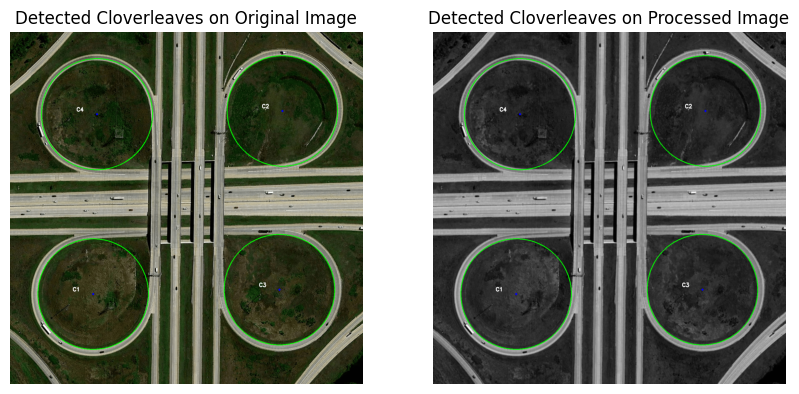

Radii: [np.uint16(189), np.uint16(189), np.uint16(189), np.uint16(190)]
Centers (x, y): 
 [[284 899]
 [931 273]
 [921 884]
 [297 284]]


In [6]:
# calculate_radii :
def detect_cloverleaves(image, processed_image):
    circles = cv2.HoughCircles(processed_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=600, param1=100, param2=2, minRadius=180, maxRadius=191)
    circles = np.uint16(np.around(circles))
    radii = []
    output_original = image.copy()
    output_processed = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)  
    for idx, circle in enumerate(circles[0, :]):
        center, radius = (circle[0], circle[1]), circle[2]
        radii.append(radius)
        for output in [output_original, output_processed]:
            cv2.circle(output, center, radius, (0, 255, 0), 2)  
            cv2.circle(output, center, 2, (255, 0, 0), 3)       
            cv2.putText(output, f"C{idx+1}", (center[0] - 70, center[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(output_original, cv2.COLOR_BGR2RGB))
    plt.title("Detected Cloverleaves on Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(output_processed, cv2.COLOR_BGR2RGB))
    plt.title("Detected Cloverleaves on Processed Image")
    plt.axis("off")
    plt.show()
    print(f"Radii: {radii}")
    print("Centers (x, y): \n", circles[0, :, :2])
    return output_original, output_processed, circles, radii

detected_original, detected_processed, detected_circles, radii = detect_cloverleaves(cloverleaf_image, proecessed_image)

### Challenges in Detecting Cloverleaf
#### Circles Low Contrast:

The cloverleaf structures lacked sufficient contrast against the background so first we convert to greyscale, and then using CLAHE to enhance local contrast.

#### Noise and Incomplete Edges:

High noise or discontinuous edges resulted in broken or false detections. Morphological closing was applied to consolidate edges before detection.

#### Overlapping Circles:

Ensuring distinct detections for overlapping or closely placed circles was challenging, overcomed using a large minDist.

### Algorithm Analysis & Failure Cases:

#### Highly Textured Background:

Noise or textured backgrounds may overwhelm the edge detection algorithm, leading to missed circles.

### Suboptimal Results:

#### Lighting Variability:
Uneven illumination affects preprocessing, resulting in inconsistent results.

#### Parameter Sensitivity:
A slight change in thresholds (param1, param2) may lead to reduced accuracy, requiring fine tuning for specific images.

In [7]:
def calculate_area(image, circles, radii):
    areas_pi_r_square = [np.pi * (r**2) for r in radii]
    pixel_areas = []
    for i, circle in enumerate(circles[0, :]):
        center, radius = (circle[0], circle[1]), circle[2]
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.circle(mask, center, radius, 255, thickness=-1) 
        pixel_area = cv2.countNonZero(mask)
        pixel_areas.append(pixel_area)
    for i, (area_pi_r_square, area_pixel_count) in enumerate(zip(areas_pi_r_square, pixel_areas)):
        print(f"\nCloverleaf {i + 1} Comparison:")
        print(f" - Area by πr²:         {area_pi_r_square:.2f} square pixels")
        print(f" - Area by Pixel Count: {area_pixel_count:.2f} square pixels")
        print(f" - Area Difference:     {(area_pixel_count - area_pi_r_square) / area_pi_r_square * 100:.2f}%")

calculate_area(cloverleaf_image, detected_circles, radii)


Cloverleaf 1 Comparison:
 - Area by πr²:         112220.83 square pixels
 - Area by Pixel Count: 112193.00 square pixels
 - Area Difference:     -0.02%

Cloverleaf 2 Comparison:
 - Area by πr²:         112220.83 square pixels
 - Area by Pixel Count: 112193.00 square pixels
 - Area Difference:     -0.02%

Cloverleaf 3 Comparison:
 - Area by πr²:         112220.83 square pixels
 - Area by Pixel Count: 112193.00 square pixels
 - Area Difference:     -0.02%

Cloverleaf 4 Comparison:
 - Area by πr²:         113411.49 square pixels
 - Area by Pixel Count: 113369.00 square pixels
 - Area Difference:     -0.04%


- **Discrete Pixels**: \(pi r^2\) assumes a perfect circle, but pixel-based areas approximate circles as grids, causing edge inaccuracies.  
- **Radius Errors**: Small inaccuracies in detected radii (\(r\)) are amplified since area scales with \(r^2\).  